In [1]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import models, layers
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import ast
import librosa

2024-04-30 12:09:19.270294: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 12:09:19.427713: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-30 12:09:19.427740: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-04-30 12:09:19.467615: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-30 12:09:20.285124: W tensorflow/stream_executor/platform/de

In [8]:
train_csv = pd.read_csv('100ms_training_data.csv')
test_csv = pd.read_csv('100ms_test_data.csv')

labels = train_csv['instrument'].unique()
#spelling error in the test_data we need to account for
label_encoder = {'Sound_Guiatr' : 0}
for index, label in enumerate(labels):
    label_encoder[label] = index

print(labels)
train_csv['instrument'].value_counts()

['Sound_Guitar' 'Sound_Drum' 'Sound_Violin' 'Sound_Piano']


instrument
Sound_Piano     21796
Sound_Drum      11783
Sound_Violin    11783
Sound_Guitar    11586
Name: count, dtype: int64

In [9]:
train_csv.head()

,Unnamed: 0,mel spec ref,instrument
0,0,1-E1-Major 00.wav-window-0.txt,Sound_Guitar
1,1,1-E1-Major 00.wav-window-1.txt,Sound_Guitar
2,2,1-E1-Major 01.wav-window-0.txt,Sound_Guitar
3,3,1-E1-Major 01.wav-window-1.txt,Sound_Guitar
4,4,1-E1-Major 02.wav-window-0.txt,Sound_Guitar


In [10]:
#preparing training data

guitar_df = train_csv[train_csv['instrument'] == 'Sound_Guitar']
piano_df = train_csv[train_csv['instrument'] == 'Sound_Drum']
drum_df = train_csv[train_csv['instrument'] == 'Sound_Violin']
violin_df = train_csv[train_csv['instrument'] == 'Sound_Piano']

#750 examples from each for intail training
data_combind_train_validation = guitar_df['mel spec ref'].tolist()[:1000]
labels_combind_train_validation = guitar_df['instrument'].tolist()[:1000]

data_combind_train_validation.extend(piano_df['mel spec ref'].tolist()[:1000])
labels_combind_train_validation.extend(piano_df['instrument'].tolist()[:1000])

data_combind_train_validation.extend(drum_df['mel spec ref'].tolist()[:1000])
labels_combind_train_validation.extend(drum_df['instrument'].tolist()[:1000])

data_combind_train_validation.extend(violin_df['mel spec ref'].tolist()[:1000])
labels_combind_train_validation.extend(violin_df['instrument'].tolist()[:1000])


#mel spec data and reshape it
for index, data in enumerate(data_combind_train_validation): 
    data_combind_train_validation[index] = np.loadtxt(f'./100ms_train_mel_spec/{data}').reshape((128, 44))
 
#change labels to 0-4   
for index, data in enumerate(labels_combind_train_validation):
    labels_combind_train_validation[index] = label_encoder[data]
    

1-E1-Major 00.wav-window-0.txt


ValueError: cannot reshape array of size 8320 into shape (128,44)

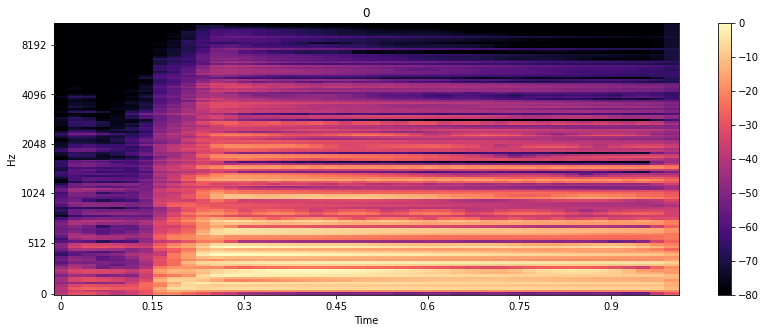

In [25]:
#testing the conversion has worked
plt.figure(figsize=(14,5))
librosa.display.specshow(data_combind_train_validation[0], sr=22050, x_axis='time', y_axis='mel')
plt.title(labels_combind_train_validation[0])
plt.colorbar()

In [26]:
test_csv['instrument'].value_counts()

instrument
Sound_Guiatr    1536
Sound_Piano     1076
Sound_Drum       843
Sound_Violin     276
Name: count, dtype: int64

In [27]:
#spelling mistake in test data - should be guitar not guiatr
guitar_df = test_csv[test_csv['instrument'] == 'Sound_Guiatr']
piano_df = test_csv[test_csv['instrument'] == 'Sound_Drum']
drum_df = test_csv[test_csv['instrument'] == 'Sound_Violin']
violin_df = test_csv[test_csv['instrument'] == 'Sound_Piano']

data_test = guitar_df['mel spec ref'].tolist()
labels_test = guitar_df['instrument'].tolist()

data_test.extend(piano_df['mel spec ref'].tolist())
labels_test.extend(piano_df['instrument'].tolist())

data_test.extend(drum_df['mel spec ref'].tolist())
labels_test.extend(drum_df['instrument'].tolist())

data_test.extend(violin_df['mel spec ref'].tolist())
labels_test.extend(violin_df['instrument'].tolist())

#mel spec data and reshape it
for index, data in enumerate(data_test): 
    data_test[index] = np.loadtxt(f'./silenced_100ms_test/{data}').reshape((128, 44))
 
#change labels to 0-4   
for index, data in enumerate(labels_test):
    labels_test[index] = label_encoder[data]
    

In [28]:
#model set up

input_shape=(128,44,1)
model = models.Sequential()
model.add(layers.Conv2D(64, (6, 6), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (6, 6), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 123, 39, 64)       2368      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 61, 19, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 61, 19, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 56, 14, 128)       295040    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 28, 7, 128)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 28, 7, 128)       

In [29]:
#history reporter
def report(history,y_pred,y_true):
    plt.plot(history.epoch, history.history["accuracy"],history.history['val_accuracy'])
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.suptitle('Training (blue) and validation (orange) History')
    plt.show()
    
    plt.figure(figsize=(10,8))
    predicted= np.argmax(y_pred,axis=1)
    cm=ConfusionMatrixDisplay(confusion_matrix(y_true=y_true, y_pred=predicted), display_labels=['Guitar', 'Drum', 'Violin', 'Piano'])#, display_labels = [False, True]) 
    cm.plot()
    plt.show()

In [30]:


x_train,x_val,y_train,y_val= train_test_split(data_combind_train_validation, labels_combind_train_validation,
                                                test_size=0.125,
                                                shuffle=True,
                                                stratify=labels_combind_train_validation)


In [31]:
early_stopping = EarlyStopping(monitor='val_loss',patience=3, 
                               min_delta=0.001,
                               restore_best_weights=True)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = model.fit(np.array(x_train), np.array(y_train),
                    epochs=20, 
                    validation_data=(np.array(x_val), np.array(y_val)),
                    callbacks=early_stopping)

Epoch 1/20


/home/michael/.local/lib/python3.10/site-packages/keras/backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


110/110 [==============================] - 69s 617ms/step - loss: 1.6068 - accuracy: 0.4234 - val_loss: 0.7842 - val_accuracy: 0.5940
Epoch 2/20
110/110 [==============================] - 67s 610ms/step - loss: 0.7230 - accuracy: 0.6343 - val_loss: 0.5707 - val_accuracy: 0.6820
Epoch 3/20
110/110 [==============================] - 75s 684ms/step - loss: 0.5999 - accuracy: 0.6703 - val_loss: 0.4886 - val_accuracy: 0.6720
Epoch 4/20
110/110 [==============================] - 77s 700ms/step - loss: 0.5387 - accuracy: 0.6846 - val_loss: 0.4417 - val_accuracy: 0.7140
Epoch 5/20
110/110 [==============================] - 78s 708ms/step - loss: 0.4888 - accuracy: 0.7077 - val_loss: 0.4750 - val_accuracy: 0.7080
Epoch 6/20
110/110 [==============================] - 78s 705ms/step - loss: 0.4690 - accuracy: 0.7151 - val_loss: 0.4122 - val_accuracy: 0.7260
Epoch 7/20
110/110 [==============================] - 78s 704ms/step - loss: 0.4431 - accuracy: 0.7163 - val_loss: 0.4163 - val_accuracy: 0.7

In [32]:
y_pred = model.predict(np.array(data_test))


117/117 [==============================] - 18s 157ms/step


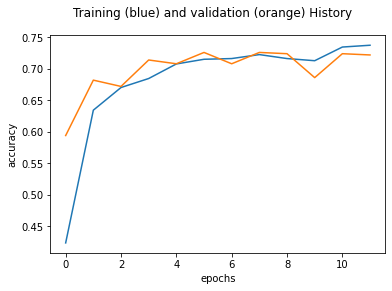

<Figure size 720x576 with 0 Axes>

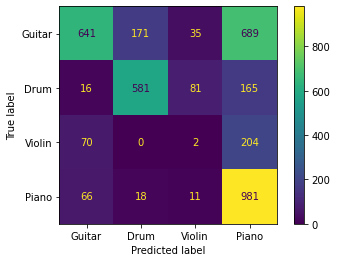

In [33]:
report(history, y_pred, labels_test)
